## Trying reverse accuracy 

Learning from segmented images without GT and apply it on images with GT to compare diff models and preproc techniques.

In [1]:
runtime_colab = False

folder = "revacc_3"
model_name = f"{folder}_unet-6v.pt"

## Colab related
if runtime_colab:
    !git clone https://github.com/ostritze/lung-segmentation.git
    import os
    os.getcwd()
    os.chdir("/content/lung-segmentation/")
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import os
import glob
import time 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize, Rotate
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
if runtime_colab:
    data_folder = Path("../drive", "MyDrive", "dataset") # colab
else:
    data_folder = Path("/media/rolyn/Data/studi/MA/", folder) # local

origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")

In [5]:
batch_size = 4

## Data loading

In [6]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
origins_list = [o for o in origins_list if not o.startswith("._")] # remove weird ._ files
masks_list = [f.stem for f in masks_folder.glob("*.png")]
masks_list = [o for o in masks_list if not o.startswith("._")] # remove weird ._ files

In [7]:
print(len(origins_list))
print(len(masks_list))

47
47


In [8]:
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]
#origin_mask_list

In [9]:
splits = {}
# we only need val, we use the test from before
splits["train"], splits["val"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
#splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)
print(len(splits["train"]), len(splits["val"]))

37 10


In [10]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(100),
    Rotate(-25, 25),
    Crop(50),
    val_test_transforms,
])

datasets = {x: LungDataset(
    splits[x], 
    origins_folder, 
    masks_folder, 
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "val"]}

torch.Size([1, 512, 512]) torch.Size([512, 512])


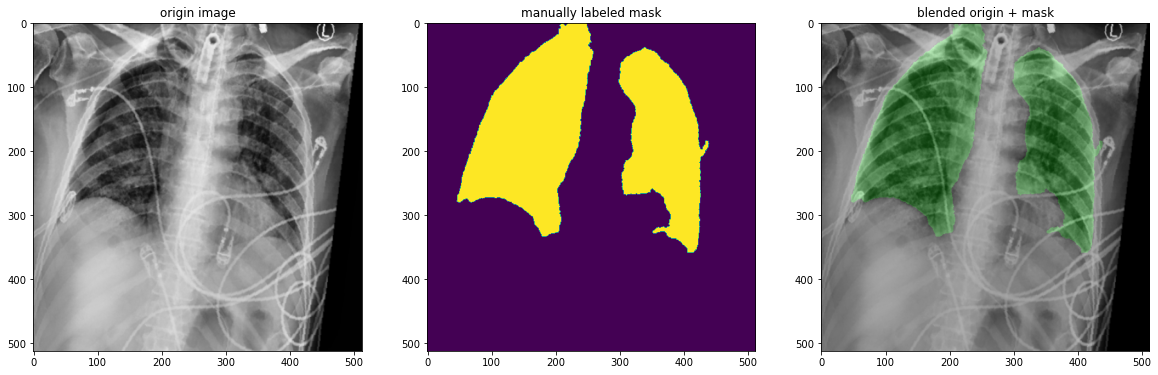

In [11]:
idx = 1
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
print(origin.shape, mask.shape)
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float())

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("manually labeled mask")
plt.imshow(np.array(pil_mask))

plt.subplot(1, 3, 3)
plt.title("blended origin + mask")
plt.imshow(np.array(blend(origin, mask)))

#plt.savefig(images_folder / "data-example.png", bbox_inches='tight')

In [12]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
from src.models import tuned_PretrainedUNet
#unet = tuned_PretrainedUNet(
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
unet

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [13]:
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [14]:
train_log_filename = "train-log-revval.txt"
epochs = 100
best_val_loss = np.inf
#model_name = "os_unet_v1.pt"

In [15]:
#early_stopping_thresh = round(epochs/10) # 10% of max epochs
#early_stopping_thresh = round(epochs/5) # 20% of max epochs
early_stopping_thresh = round(epochs) # literally none :-)
#early_stopping_thresh = 1
early_stop_cnt = -1

hist = []

for e in range(epochs):
    start_t = time.time()
    
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)
        
        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        print(".", end="")
        
    train_loss = train_loss / len(datasets['train'])
    print()
    
    
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            early_stop_cnt = e

            best_val_loss = val_loss
            torch.save(unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        else:
            if (e - early_stop_cnt) >= early_stopping_thresh:
                print(f"early stopping reached at epoch {e}!")
                train_log_file.write(f"early stopping reached at epoch {e}!\n")
                break
        print()

        

train phase


/home/rolyn/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


..........
validation phase
...
epoch: 1/100, time: 11.332894086837769, train loss: 0.3906948292577589, 
val loss: 1.2230572700500488, val jaccard: 0.0, val dice: 0.0
model saved

train phase
..........
validation phase
...
epoch: 2/100, time: 10.966187238693237, train loss: 0.25489177816622965, 
val loss: 0.5698391437530518, val jaccard: 0.3290587604045868, val dice: 0.47795073986053466
model saved

train phase
..........
validation phase
...
epoch: 3/100, time: 11.38162350654602, train loss: 0.22090727654663292, 
val loss: 0.5287017583847046, val jaccard: 0.0, val dice: 0.0
model saved

train phase
..........
validation phase
...
epoch: 4/100, time: 11.19954800605774, train loss: 0.19148527528788592, 
val loss: 0.63821382522583, val jaccard: 0.0, val dice: 0.0

train phase
..........
validation phase
...
epoch: 5/100, time: 11.118552446365356, train loss: 0.1907747194573686, 
val loss: 0.5989015340805054, val jaccard: 0.00034788930788636206, val dice: 0.0006945680361241102

train pha

epochs: 100, overall time: 18.0m, mean epoch time: 11.106337337493896s


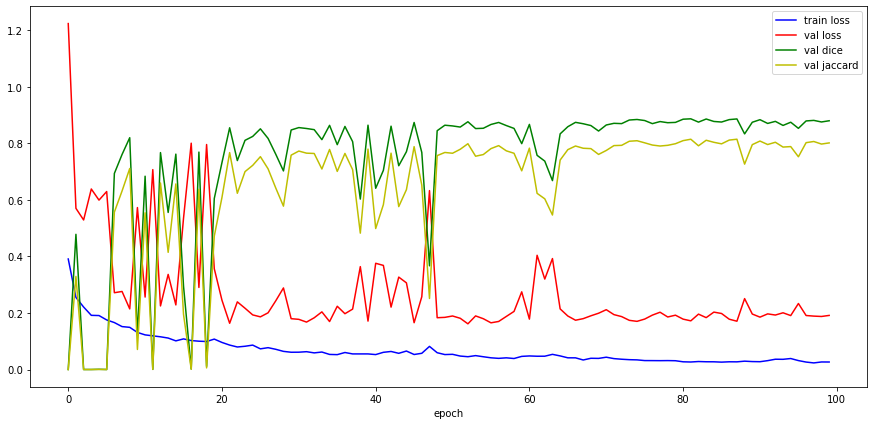

In [16]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [17]:
torch.cuda.empty_cache()

## Evaluate

In [18]:
unet = PretrainedUNet(1, 2, True, "bilinear")

In [19]:
#model_name = "os_unet_v1.pt"
print(model_name)
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

revacc_3_unet-6v.pt


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [20]:
#now load the original training data we have GT for 

if runtime_colab:
    data_folder = Path("../drive", "MyDrive", "dataset") # colab
else:
    data_folder = Path("/media/rolyn/Data/studi/MA/", "dataset") # local

origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")

origins_list = [f.stem for f in origins_folder.glob("*.png")]
origins_list = [o for o in origins_list if not o.startswith("._")] # remove weird ._ files
masks_list = [f.stem for f in masks_folder.glob("*.png")]
masks_list = [o for o in masks_list if not o.startswith("._")] # remove weird ._ files

print(len(origins_list))
print(len(masks_list))

origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]
print(len(origin_mask_list))
original_splits = {}
original_splits["train"], original_splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
#splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

#split_file = "splits.pk"
#if os.path.isfile(split_file):
#    with open("splits.pk", "rb") as f:
#        original_splits = pickle.load(f)

800
704
704


In [21]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(300),
    Rotate(-25, 25),
    Crop(300),
    val_test_transforms,
])

datasets = {x: LungDataset(
    original_splits[x], 
    origins_folder, 
    masks_folder, 
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test"]}

In [22]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print("Scores on {} test images: ".format(len(datasets["test"])))
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

#  .convert("P"):
# Scores on 141 test images: 
# avg test loss: 0.3567084532680241
# avg test jaccard: 0.6966917132232207
# avg test dice: 0.8003778605596393


....................................
Scores on 141 test images: 
avg test loss: 0.11416173330012788
avg test jaccard: 0.8560241118390509
avg test dice: 0.919068990024269


.........
red area - predict
green area - ground truth
yellow area - intersection


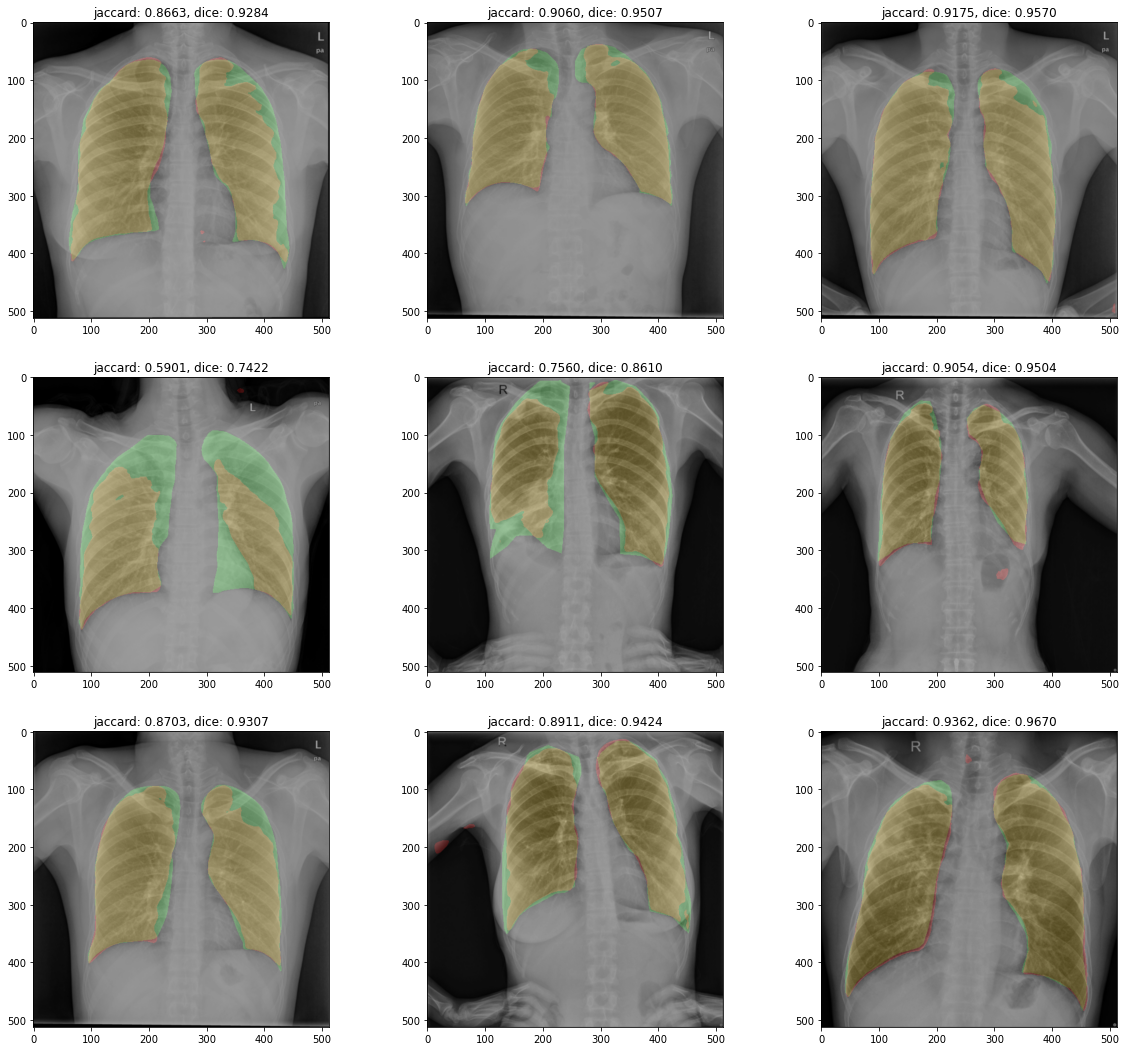

In [23]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.arange(num_samples) 
    #np.random.randint(0, len(datasets[phase]), num_samples)
)

random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)
    

    origin = origin.to(device)
    #origin = (origin*(-1)).to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)), cmap="gray")
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")
            
plt.savefig(images_folder / f"obtained-results_{model_name}.png", bbox_inches='tight')
print() 
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")